# Titanic Survival Prediction
## Comparative Analysis: LightGBM vs XGBoost


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

In [2]:
train_df = pd.read_csv('/content/Titanic_train.csv')
test_df  = pd.read_csv('/content/Titanic_test.csv')
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Exploratory Data Analysis (EDA)

In [3]:
train_df.isnull().sum()

,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,177
SibSp,0
Parch,0
Ticket,0
Fare,0


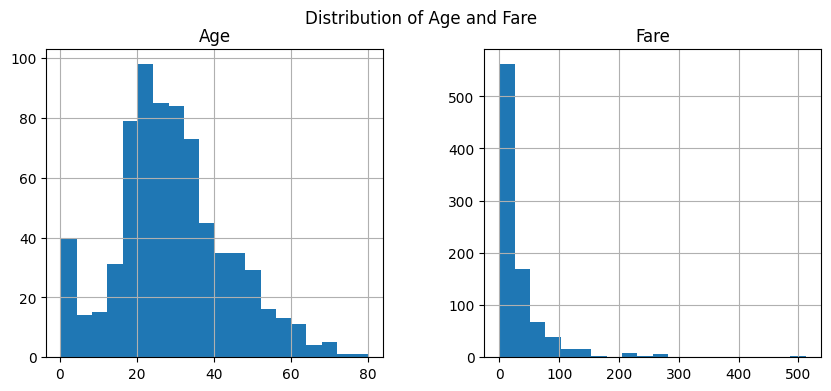

In [4]:
train_df[['Age','Fare']].hist(bins=20, figsize=(10,4))
plt.suptitle('Distribution of Age and Fare')
plt.show()

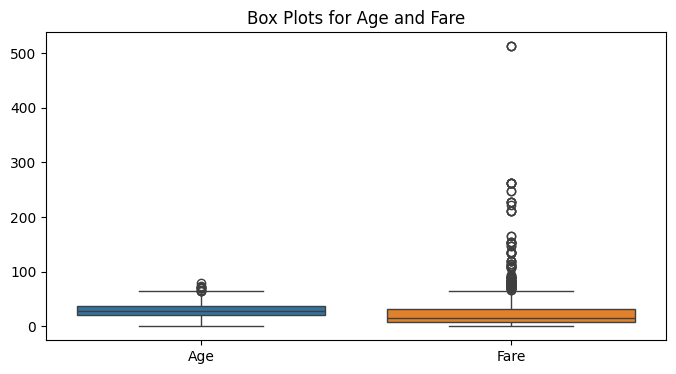

In [5]:
plt.figure(figsize=(8,4))
sns.boxplot(data=train_df[['Age','Fare']])
plt.title('Box Plots for Age and Fare')
plt.show()

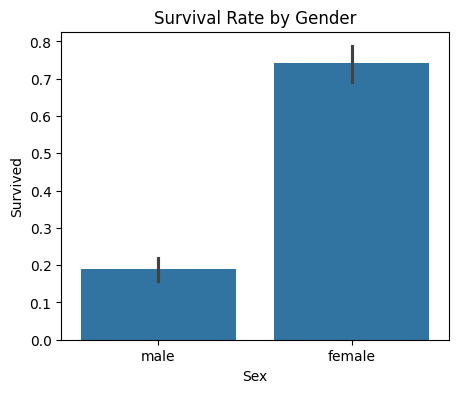

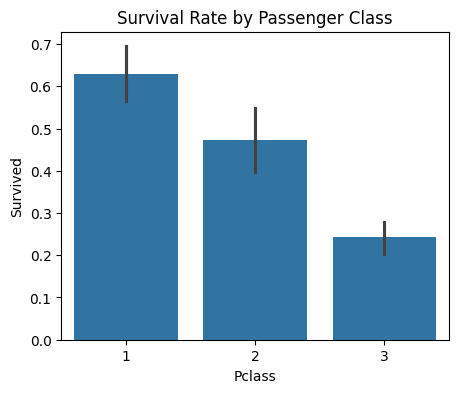

In [6]:
plt.figure(figsize=(5,4))
sns.barplot(x='Sex', y='Survived', data=train_df)
plt.title('Survival Rate by Gender')
plt.show()

plt.figure(figsize=(5,4))
sns.barplot(x='Pclass', y='Survived', data=train_df)
plt.title('Survival Rate by Passenger Class')
plt.show()

## Data Preprocessing

In [7]:
full_df = pd.concat([train_df, test_df])

full_df['Age'].fillna(full_df['Age'].median(), inplace=True)
full_df['Fare'].fillna(full_df['Fare'].median(), inplace=True)
full_df['Embarked'].fillna(full_df['Embarked'].mode()[0], inplace=True)

full_df.drop(['Cabin','Name','Ticket'], axis=1, inplace=True)

for col in ['Sex','Embarked']:
    full_df[col] = LabelEncoder().fit_transform(full_df[col])

train_processed = full_df[:len(train_df)]
X = train_processed.drop('Survived', axis=1)
y = train_processed['Survived']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

## Hyperparameter Tuning & Model Training

In [9]:
lgbm_params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5]
}

lgbm_grid = GridSearchCV(LGBMClassifier(random_state=42),
                         lgbm_params,
                         cv=5,
                         scoring='accuracy')
lgbm_grid.fit(X_train, y_train)
best_lgbm = lgbm_grid.best_estimator_

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

In [10]:
xgb_params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5]
}

xgb_grid = GridSearchCV(
    XGBClassifier(random_state=42, eval_metric='logloss', use_label_encoder=False),
    xgb_params,
    cv=5,
    scoring='accuracy'
)
xgb_grid.fit(X_train, y_train)
best_xgb = xgb_grid.best_estimator_

## Model Evaluation & Comparison

In [11]:
def evaluate(y_true, y_pred):
    return [
        accuracy_score(y_true, y_pred),
        precision_score(y_true, y_pred),
        recall_score(y_true, y_pred),
        f1_score(y_true, y_pred)
    ]

metrics = pd.DataFrame({
    'Metric': ['Accuracy','Precision','Recall','F1-score'],
    'LightGBM': evaluate(y_test, best_lgbm.predict(X_test)),
    'XGBoost': evaluate(y_test, best_xgb.predict(X_test))
})

metrics

,Metric,LightGBM,XGBoost
0,Accuracy,0.798883,0.804469
1,Precision,0.823529,0.793103
2,Recall,0.608696,0.666667
3,F1-score,0.700000,0.724409


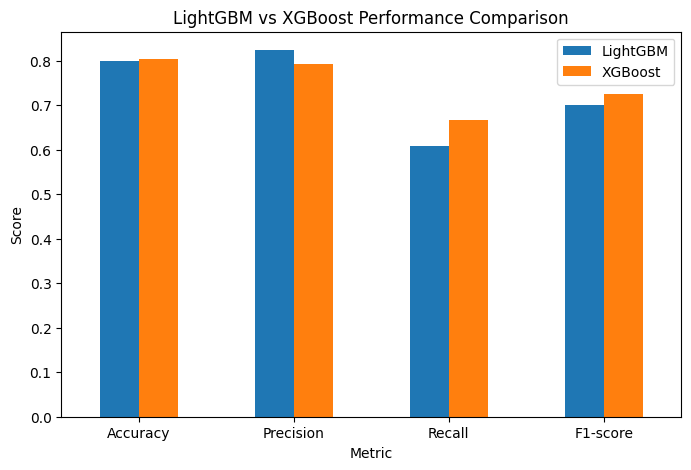

In [12]:
metrics.set_index('Metric').plot(kind='bar', figsize=(8,5))
plt.title('LightGBM vs XGBoost Performance Comparison')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.show()

## Conclusion
- Comprehensive EDA reveals survival dependency on gender and passenger class.
- Hyperparameter tuning improves both models’ performance.
- LightGBM is computationally efficient, while XGBoost is robust with careful tuning.